<a href="https://colab.research.google.com/github/srihiyacine/temperature_Nakuri-autoregression/blob/main/temperature_Nakuri_autoregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt


In [ ]:
file_path = "/content/august_2021_sensor_data_archive (1).csv"
df = pd.read_csv(file_path , delimiter=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,145,DHT22,3528,-0.286,36.067,2021-08-03T07:20:18.209955+00:00,humidity,55
1,145,DHT22,3528,-0.286,36.067,2021-08-03T07:20:18.209955+00:00,temperature,22
2,144,SDS011,3528,-0.286,36.067,2021-08-03T07:20:18.211556+00:00,P2,4
3,144,SDS011,3528,-0.286,36.067,2021-08-03T07:20:18.211556+00:00,P1,5
4,144,SDS011,3528,-0.286,36.067,2021-08-03T07:22:58.571931+00:00,P2,4


In [ ]:
def wrangle(df):


  #filtre  for temperature
  df = df[df["value_type"]=="temperature"]

  #select times and value
  df = df[["timestamp","value"]]
  df.rename(columns={"value":"temperature","timestamp":"time"}, inplace=True)
  #select time as index
  df.set_index("time", inplace=True)
  #index transfering to date type
  df.index = pd.to_datetime(df.index)
  #transfer time
  df.index = df.index.tz_convert("Africa/Nairobi")

  #resample for 1H window
  df = df["temperature"].resample("1H").mean()

  # add lag feature
  #df["temperature.L3"] = df["temperature"].shift(3)
  #df["temperature.L6"] = df["temperature"].shift(6)
  # drop nan rows
  #df.dropna(inplace=True)



  return df

In [ ]:
df = wrangle(df)
df.head()

time
2021-08-03 10:00:00+03:00    22.250000
2021-08-03 11:00:00+03:00    24.500000
2021-08-03 12:00:00+03:00    26.956522
2021-08-03 13:00:00+03:00    27.227273
2021-08-03 14:00:00+03:00    28.086957
Freq: H, Name: temperature, dtype: float64

In [ ]:

#print(df["temperature"].corr(df["temperature.L3"]))

#print(df["temperature"].corr(df["temperature.L6"]))


# 2- Explore: create  ACF and PACF plots

In [ ]:
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

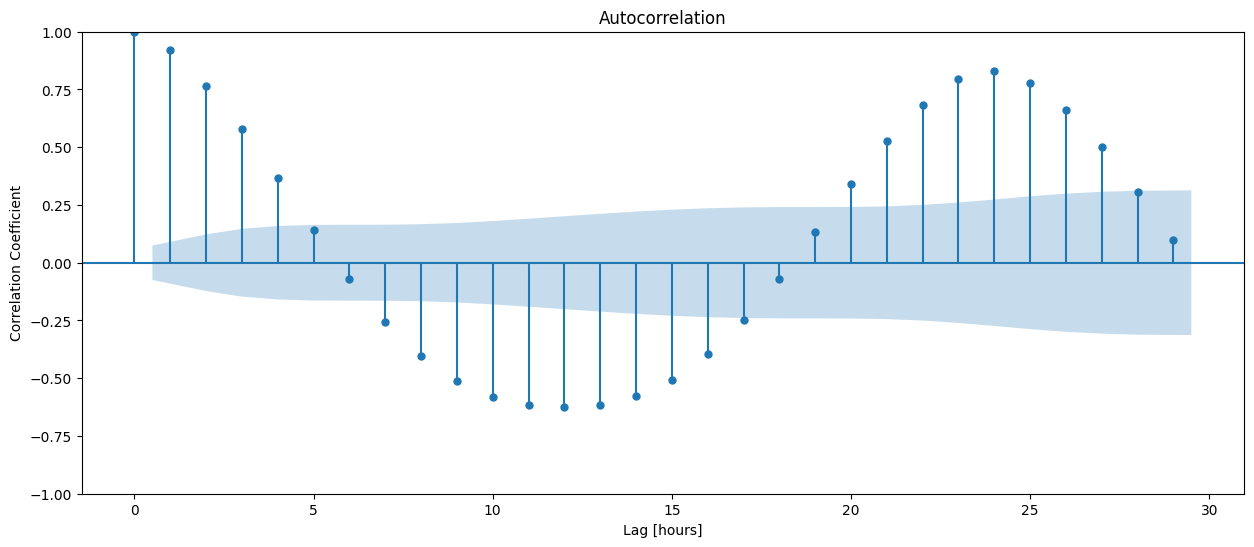

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

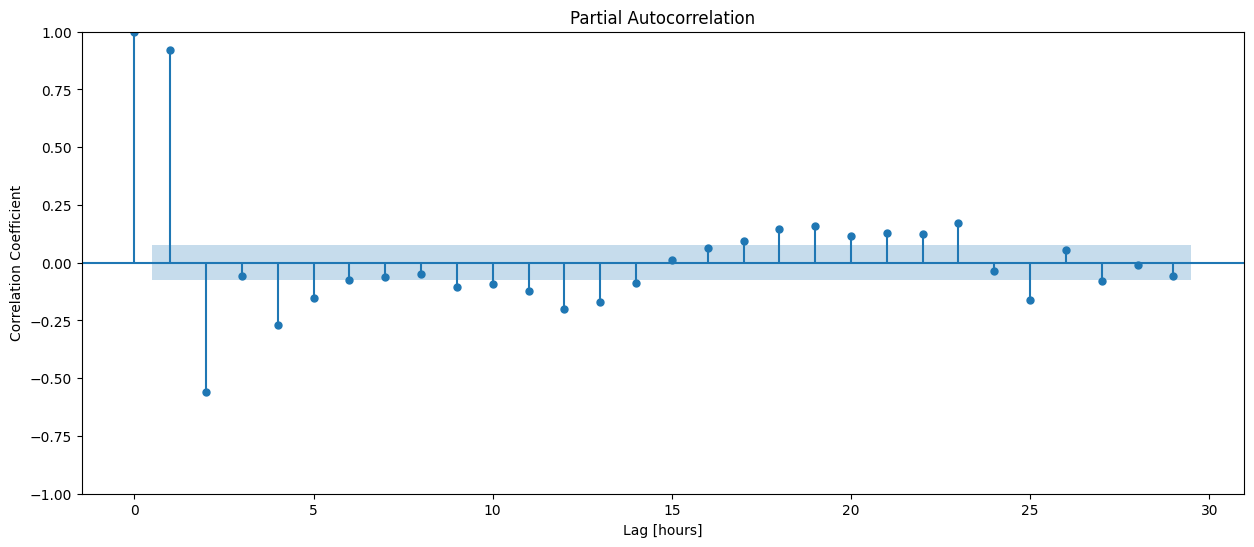

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

# 3-Split Train-Test Data

In [ ]:
# 80% train data, 20% test data
cutoff = int(len(df) * 0.8)

df_train = df.iloc[:cutoff]
df_test =df.iloc[cutoff:]

# Building Autoregressive (AR) Model

# 1-Baseline

In [ ]:
df_train_mean = df_train.mean()
df_pred_baseline = [df_train_mean] * len(df_train)
mae_baseline = mean_absolute_error(df_train, df_pred_baseline)

print("Mean P2 Reading:", round(df_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 20.13
Baseline MAE: 4.43


# 2-Build the AR model

In [ ]:
model = AutoReg(df_train, lags=24).fit()

In [ ]:

#  calculate train mean absolute error
df_pred = model.predict().dropna()
training_mae = mean_absolute_error(df_train.iloc[24:], df_pred)
print("Training MAE:", training_mae)

Training MAE: 0.8514273305036805


<Axes: xlabel='time', ylabel='Residual Value'>

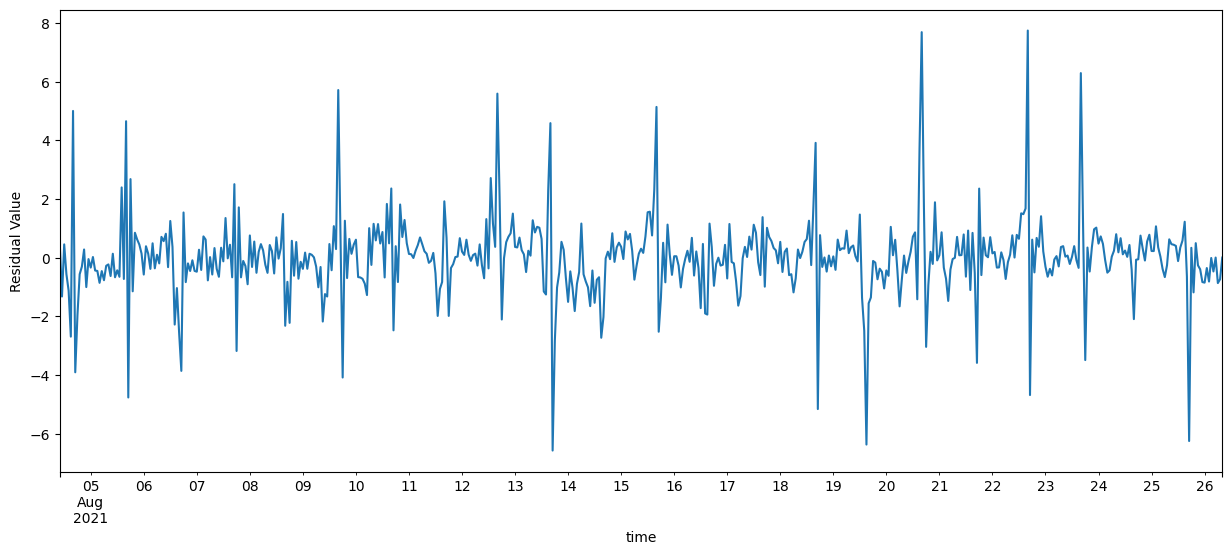

In [ ]:

# calculate the residuals for the model and plot them.
df_train_resid = model.resid
# Time series plot
fig, ax = plt.subplots(figsize=(15, 6))
df_train_resid.plot(ylabel="Residual Value", ax=ax)

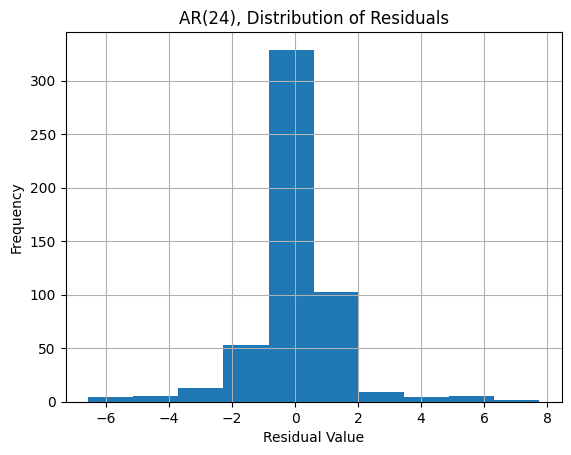

In [ ]:

# Histogram plot
df_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(24), Distribution of Residuals");

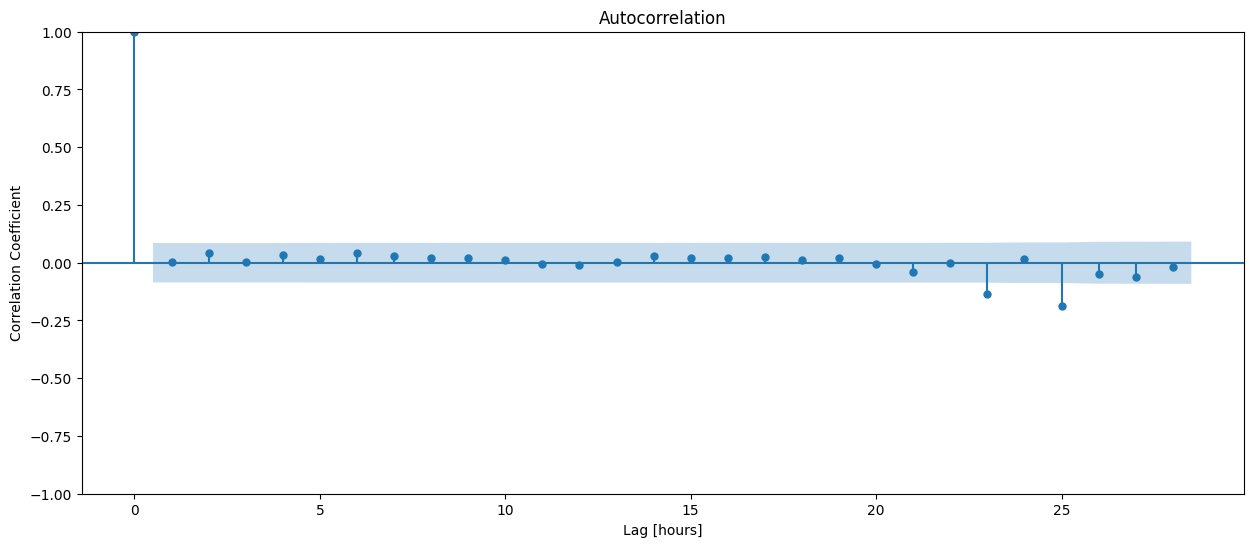

In [ ]:
#  ACF plot of `df_train_resid`
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [ ]:
df_pred_test = model.predict(df_test.index.min(), df_test.index.max())
test_mae = mean_absolute_error(df_test, df_pred_test)
print("Test MAE:", test_mae)

Test MAE: 2.031321085100787


In [ ]:
print("Is Training MAE less than the Baseline MAE:", training_mae < mae_baseline)
print("Is Test MAE less than the Baseline MAE:", test_mae < mae_baseline)

Is Training MAE less than the Baseline MAE: True
Is Test MAE less than the Baseline MAE: True


In [ ]:
df_test.head()

time
2021-08-26 09:00:00+03:00    18.954545
2021-08-26 10:00:00+03:00    22.000000
2021-08-26 11:00:00+03:00    25.045455
2021-08-26 12:00:00+03:00    27.500000
2021-08-26 13:00:00+03:00    29.454545
Freq: H, Name: temperature, dtype: float64

In [ ]:
df_pred_test = pd.DataFrame(
    {"df_test": df_test,
     "df_pred": df_pred_test.values}, index=df_test.index

)


In [ ]:
fig = px.line(df_pred_test, labels={"value": "temperature"})
fig.show()
fig.write_html("/content/plot_Autoregressive_Model_without_wfv.html")


Why is my model performing poorly? because it is using 24 lag data to predict the new value and at some point, the model is using a predicted values to get (calculate) a new predict value. What is the solution? walk-forward validation

In [ ]:
type(df_train)

pandas.core.series.Series

In [ ]:
df_pred_wfv = pd.Series()
history = df_train.copy()

In [ ]:
type(df_train)

pandas.core.series.Series

In [ ]:
history.head()

time
2021-08-03 10:00:00+03:00    22.250000
2021-08-03 11:00:00+03:00    24.500000
2021-08-03 12:00:00+03:00    26.956522
2021-08-03 13:00:00+03:00    27.227273
2021-08-03 14:00:00+03:00    28.086957
Freq: H, Name: temperature, dtype: float64

In [ ]:
# Perform walk-forward validation for your model for the entire test set df_test
%%capture
df_pred_wfv = pd.Series()
history = df_train.copy()

for i in range(len(df_test)):

    r = AutoReg(history, 24, old_names=False).fit()
    next_pred = r.forecast()
    print(next_pred,  next_pred.index)
    df_pred_wfv = pd.concat([df_pred_wfv, next_pred])
    history = pd.concat([history ,df_test[next_pred.index]])

In [ ]:
test_mae = mean_absolute_error(df_test, df_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.9


In [ ]:

print(model.params)

const              3.295110
temperature.L1     1.038205
temperature.L2    -0.441361
temperature.L3     0.213292
temperature.L4    -0.052483
temperature.L5    -0.055989
temperature.L6    -0.008962
temperature.L7    -0.070110
temperature.L8     0.036184
temperature.L9    -0.029618
temperature.L10   -0.003736
temperature.L11    0.062299
temperature.L12    0.020622
temperature.L13   -0.045316
temperature.L14   -0.037618
temperature.L15   -0.050433
temperature.L16    0.023270
temperature.L17   -0.011547
temperature.L18   -0.013818
temperature.L19    0.065132
temperature.L20   -0.029947
temperature.L21    0.093970
temperature.L22   -0.091514
temperature.L23    0.220678
temperature.L24    0.005101
dtype: float64


In [ ]:
df_pred_test = pd.DataFrame(
    {"df_test": df_test, "df_pred_wfv": df_pred_wfv}, index=df_test.index
)
fig = px.line(df_pred_test, labels={"value": "temperature"})
fig.show()
fig.write_html("/content/plot_Autoregressive_Model_wfv.html")

The plot effectively illustrates the performance of the AutoRegressive model in predicting temperature over a short time frame. The model captures the overall trend and daily fluctuations in temperature reasonably well, with some minor prediction errors. This visualization can be a valuable tool for analyzing and presenting the performance of time series forecasting models.